# Computer Vision - Project
imports

In [68]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
import requests
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
import h5py, requests, os
import matplotlib.patches as patches
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization, ZeroPadding2D, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import LSTM
from keras.layers import Resizing
from tqdm import tqdm

In [69]:
# IMG_SIZE = (64, 64)
# IMG_SHAPE = IMG_SIZE + (3,)
# base_model = tf.keras.applications.resnet(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
# base_model.trainable = False

Constants

In [70]:
#ZIP_PATH = "https://drive.google.com/drive/folders/1jzHYpTwywUYA53nMGHVROSuVO14hEueq?usp=sharing/"
FILE_NAME ="SynthText_train.h5"
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.clear_session()
SIZE=224


In [71]:
def sort_points(points, center):
    # calculate the angle of each point from the center point
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    # sort the points by angle
    sorted_points = points[np.argsort(angles)]
    return sorted_points

In [72]:
def draw_training_curve(history):
	"""
	Draw training curve
	Parameters:
		history - contains loss and accuracy from training
	Returns:
		None
	"""
	plt.figure(1)

	# History for accuracy
	plt.subplot(211)
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	# History for loss
	plt.subplot(212)
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	plt.show()

In [73]:
def draw_points(image, points, color=(255, 0, 0), radius=3):
    # create a copy of the image
    img = image.copy()
    # iterate over the points and draw them on the image
    for point in points:
        cv2.circle(img, tuple(map(int, point)), radius, color, -1)
    return img


In [75]:
def font_to_num(font):
    if font == b'Alex Brush':
        return 0
    elif font == b'Titillium Web':
        return 1
    elif font == b'Sansation':
        return 2
    elif font == b'Open Sans':
        return 3
    else:
        return 4

In [76]:
def num_to_font(font):
    if font == 0:
        return b'Alex Brush'
    elif font == 1:
        return b'Titillium Web'
    elif font == 2:
        return b'Sansation'
    elif font == 3:
        return b'Open Sans'
    else:
        return b'Ubuntu Mono'

In [77]:
def print_label(set, index):
    line = set[index]
    max = np.argmax(line)
    print(num_to_font(max))

In [78]:
def print_font(max):
     print(num_to_font(max))

In [79]:
def print_photo_from_set(set_x, set_y, index, font):
    plt.imshow(set_x[index], cmap='gray')
    plt.show()
    print_font(font)

In [80]:

def prepare_img(img, bbs, index, size):
    x1 = int(bbs[0,0,index])
    y1 = int(bbs[1,0,index])
    x2 = int(bbs[0,1,index])
    y2 = int(bbs[1,1,index])
    x3 = int(bbs[0,2,index])
    y3 = int(bbs[1,2,index])
    x4 = int(bbs[0,3,index])
    y4 = int(bbs[1,3,index])
    # calculate bounding rectangle
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))

    cropped = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    # _, cropped = cv2.threshold(cropped,127,255,cv2.THRESH_TRIANGLE)
    # print(cropped.shape)
    cropped = tf.image.resize(cropped, (size, size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # cropped = tf.image.rgb_to_grayscale(cropped)
    # # print(cropped.shape)
    cropped = tf.image.convert_image_dtype(cropped, tf.float32)
    # plt.imshow(cropped, cmap='gray')
    # plt.show()
    return cropped

In [81]:
from pathlib import Path
def create_dirs():
    Path('main_directory').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Alex Brush').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Titillium Web').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Sansation').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Open Sans').mkdir(parents=True, exist_ok=True)
    Path('main_directory/Ubuntu Mono').mkdir(parents=True, exist_ok=True)

In [82]:
def is_num_or_letter(inp):
    # res= ((inp >= ord('a') and inp <= ord('z')) or (inp >= ord('A') and inp <= ord('Z'))) or (inp>=ord('0') and inp<=ord('9'))
    # # print(chr(inp)+"="+str(res))
    if(inp==ord('.') or inp==ord(',') or inp==ord(':') or inp==ord(';')):
        return False
    return True

In [83]:
db = h5py.File(FILE_NAME, 'r')

In [192]:
def get_data_set(db, size: int):
    
    create_dirs()
    im_names = list(db['data'].keys())
    train_x = []
    train_y = []
    num = 0
    for i in tqdm(range(0, len(im_names)-1)):
        im = im_names[i]
        img  = db['data'][im][:]
        fonts = db['data'][im].attrs['font']
        txts = db['data'][im].attrs['txt']
        charBBs = db['data'][im].attrs['charBB']
        wordBBs = db['data'][im].attrs['wordBB']
        font_indx = 0 
        char_indx = 0
        # print(im)
        for j in range(0, len(txts)):
            if(j%8!=0):
                cropped = prepare_img(img, wordBBs, j, size)
                path = 'main_directory/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
                # print(path)
                tf.keras.utils.save_img(path,cropped)
                # db['data'][im] = 0
                num+=1
                for k in range(0, len(txts[j])):
                    if(is_num_or_letter(txts[j][k])):
                        cropped = prepare_img(img, charBBs, char_indx, size)
                        path = 'main_directory/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg'
                        # print(path)
                        tf.keras.utils.save_img(path,cropped)
                        num+=1
                        # train_x.append(cropped)
                        # train_y.append(font_to_num(fonts[font_indx]))
                    char_indx+=1
                        # plt.imshow(cropped, cmap='gray')
                        # plt.show()
                        # print(fonts[font_indx])
            else:
                # cropped = prepare_img(img, wordBBs, j, size)
                # db['data'][im][:].resize(224,224,3)
                # db['data'][im][:] = cropped
                # name = 'test_set/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
                # add_res_to_db(db_test,name,cropped,charBBs[:,:,j:j+len(txts[j])], wordBBs[:,:,j], txts[j])
                # path = 'test_set/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
                # tf.keras.utils.save_img(path,cropped)
                char_indx+=len(txts[j])
            font_indx += len(txts[j])
    print(num)
    # return train_x, train_y

In [85]:
from download_h5py_db import download_h5py_db
if not Path("main_directory").exists():
    download_h5py_db()
    get_data_set(db, SIZE)
# train_x, train_y = 

In [141]:
import splitfolders
splitfolders.ratio("main_directory/", # The location of dataset
                   output="main_directory_splitted", # The output location
                   seed=42, # The number of seed
                   ratio=(.8, .1, .1), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 29840 files [00:54, 544.96 files/s]


In [143]:
from keras.preprocessing.image import ImageDataGenerator
def data_augmentation():
    datagen =  ImageDataGenerator(
        horizontal_flip=True, rotation_range=90, fill_mode='reflect', channel_shift_range=0.8,#
         shear_range=15,vertical_flip=False, brightness_range=(0.2, 0.8),# 
     rescale=1/255, dtype='float32'
     #,validation_split=0.25
     )
    # Path('augmented').mkdir(exist_ok=True)
    it = datagen.flow_from_directory('main_directory_splitted/train/', batch_size=18, class_mode='categorical',
    #save_to_dir='augmented',
     shuffle=True, seed=1, keep_aspect_ratio=True)
    datagen_val =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
    val_it = datagen_val.flow_from_directory('main_directory_splitted/val/', batch_size=18, class_mode='categorical',
    #save_to_dir='augmented',
     shuffle=True)
    test_it = datagen_val.flow_from_directory('main_directory_splitted/test/', batch_size=18, class_mode='categorical',
    #save_to_dir='augmented',
     shuffle=True)
    return it, val_it,test_it, datagen

In [144]:
it, val_it,test_it, datagen = data_augmentation()

Found 23869 images belonging to 5 classes.
Found 2981 images belonging to 5 classes.
Found 2990 images belonging to 5 classes.


Found 27011 images belonging to 5 classes.
Found 9000 images belonging to 5 classes.

In [88]:
# datagen.fit(it, augment=True, seed=0.8, rounds=5)

In [210]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GaussianNoise

from keras import regularizers

num_classes = 5
input_size= SIZE

baseModel = tf.keras.applications.ResNet50(include_top=False, classes=num_classes,
                         input_shape=(input_size, input_size, 3),
                        weights='imagenet')
headModel = baseModel.output
headModel = GaussianNoise(0.1)(headModel)
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)    
model.compile(optimizer=tf.keras.optimizers.Adam(0.00003), loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision()])

In [90]:
def scheduler(epoch, lr):
    # if epoch < 5:
    #     return lr
    # else:
    return lr * 0.1 #tf.math.exp(-0.1)

In [91]:
# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [252]:
# model.fit(X_train, Y_train, batch_size=16, epochs=20)
# datagen.fit(X_train)
if not os.path.isfile('model_res/saved_model.pb'):
  history = model.fit(it, epochs=15, shuffle=True, validation_data=val_it, verbose=1
          #   ,callbacks=[callback]
            )
else:
  model = tf.keras.models.load_model('model_res')

In [212]:
score = model.evaluate(test_it)

167/167 [==============================] - 23s 132ms/step - loss: 2.4362 - precision: 0.8215


In [96]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.7082432508468628 / Test accuracy: 0.7474002242088318


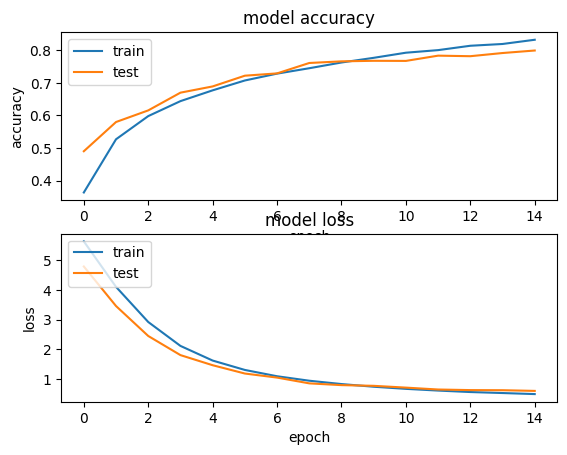

In [158]:
draw_training_curve(history)

In [260]:
model.save('model_res')

INFO:tensorflow:Assets written to: model_res\assets


INFO:tensorflow:Assets written to: model_res\assets


In [243]:
# test_path = 'test_diresctory'
Path('check_test').mkdir(parents=True, exist_ok=True)
Path('check_test/Alex Brush').mkdir(parents=True, exist_ok=True)
Path('check_test/Titillium Web').mkdir(parents=True, exist_ok=True)
Path('check_test/Sansation').mkdir(parents=True, exist_ok=True)
Path('check_test/Open Sans').mkdir(parents=True, exist_ok=True)
Path('check_test/Ubuntu Mono').mkdir(parents=True, exist_ok=True)
size=SIZE
im_names = list(db['data'].keys())
num = 0
prediction_arr=[]
test_y = []
for i in tqdm(range(0, int((len(im_names)-1)/8))):
    im = im_names[i]
    img  = db['data'][im][:]
    fonts = db['data'][im].attrs['font']
    txts = db['data'][im].attrs['txt']
    charBBs = db['data'][im].attrs['charBB']
    wordBBs = db['data'][im].attrs['wordBB']
    font_indx = 0 
    char_indx = 0
    # print(im)
    for j in range(0, len(txts)):
        if(j%8!=0):
            test_x = []
            cropped = prepare_img(img, wordBBs, j, size)
            path = 'check_test/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg' 
            # cropped = tf.image.convert_image_dtype(cropped, dtype=tf.float32) 
            tf.keras.utils.save_img(path,cropped)
            test_x.append(cropped)
            num+=1            
            for k in range(0, len(txts[j])):
                if(is_num_or_letter(txts[j][k])):
                    cropped = prepare_img(img, charBBs, char_indx, size)
                    path = 'check_test/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.jpg'
                    tf.keras.utils.save_img(path,cropped)
                    # cropped = tf.image.convert_image_dtype(cropped, dtype=tf.float32) 
                    # print(cropped)
                    test_x.append(cropped)
                    num+=1
                char_indx+=1
            test_x = np.asarray(test_x, dtype=np.float32)
            # print(test_x)
            reses = model.predict_on_batch(test_x)
            # print(reses)
            maxes = np.argmax(reses, axis=1)
            prediction = np.bincount(maxes).argmax()
            for k in range(0, len(txts[j])):
                test_y.append(font_to_num(fonts[font_indx]))
                prediction_arr.append(prediction)
            # if(fonts[font_indx]==b'Open Sans'):
            # print(txts[j])
            # for imi in test_x:
            #     plt.imshow(imi)
            #     plt.show()
            # print(maxes)
            # print(reses)
            # # print(prediction)
            # print(fonts[font_indx])
            # print(num_to_font(prediction))
            # print(test_x)
            # print(str(np.bincount(maxes).argmax())+"-"+str(font_to_num(fonts[font_indx])))
            # print(np.bincount(maxes).argmax())
        else:
            char_indx+=len(txts[j])
        font_indx += len(txts[j])

100%|██████████| 124/124 [01:42<00:00,  1.21it/s]


In [246]:
from sklearn.metrics import classification_report
labels=['Alex Brush','Titillium Web','Sansation','Open Sans','Ubuntu Mono']
print(classification_report(test_y, prediction_arr, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.63      0.99      0.77       671
Titillium Web       0.22      0.24      0.23       605
    Sansation       0.60      0.33      0.43       751
    Open Sans       0.12      0.12      0.12       440
  Ubuntu Mono       0.88      0.78      0.82       700

     accuracy                           0.52      3167
    macro avg       0.49      0.49      0.47      3167
 weighted avg       0.53      0.52      0.51      3167



In [248]:
datagen_t =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
t_it = datagen_t.flow_from_directory('check_test', batch_size=18, class_mode='categorical',
#save_to_dir='augmented',
    )

Found 3850 images belonging to 5 classes.


In [231]:
score = model.evaluate(it)

 176/1327 [==>...........................] - ETA: 20:10 - loss: 2.3653 - precision: 0.8222

KeyboardInterrupt: 

In [232]:
score = model.evaluate(val_it)

166/166 [==============================] - 50s 297ms/step - loss: 2.4366 - precision: 0.8116


In [249]:
score = model.evaluate(t_it)

214/214 [==============================] - 51s 235ms/step - loss: 2.4477 - precision: 0.8242


In [247]:
predict = model.predict(t_it)

FileNotFoundError: [Errno 2] No such file or directory: 'check_test\\Alex Brush\\tennis_133.jpg_0_6040.jpg'

In [244]:
# print(predict)

In [245]:
# print(test_y)

In [161]:
# print(test_y)

In [250]:
# print(prediction_arr)

In [100]:
prediction_arr_cat = np_utils.to_categorical(prediction_arr, 5)
test_y_cat = np_utils.to_categorical(test_y, 5)

In [228]:
print(len(test_y))
print(len(prediction_arr))

3167
3167


In [218]:
import tensorflow as tf

m = tf.keras.metrics.AUC()

m.update_state(test_y, prediction_arr) # assuming both have shape (N,)

r = m.result().numpy()

print(r)

0.8907568


In [223]:
# print(test_y)

In [222]:
# print(prediction_arr)

In [154]:
y_true = test_y
y_pred = prediction_arr
kacc = tf.keras.metrics.Accuracy()
_ = kacc.update_state(y_true, y_pred)
print(f'Keras Accuracy acc: {kacc.result().numpy()*100:.3}')

kbacc = tf.keras.metrics.BinaryAccuracy()
_ = kbacc.update_state(y_true, y_pred)
print(f'Keras BinaryAccuracy acc: {kbacc.result().numpy()*100:.3}')

print(f'SkLearn acc: {accuracy_score(y_true, y_pred)*100:.3}')

Keras Accuracy acc: 56.7
Keras BinaryAccuracy acc: 37.4
SkLearn acc: 56.7
